In [1]:
# Import patch first
import langchain_patch


# COMMON IMPORTS
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langchain.tools import tool

from pydantic import BaseModel, Field
from typing_extensions import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langchain_core.messages import ( HumanMessage, SystemMessage, AIMessage, ToolMessage, AnyMessage)


from langgraph.graph.message import add_messages
import asyncio, random, os
from playwright.async_api import async_playwright
from langchain_mcp_adapters.client import MultiServerMCPClient
load_dotenv()



✓ Applied langchain-mcp-adapters compatibility patch


/home/aidodo/Foundations_of_AgenticAI/agentic-labs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
class Property(BaseModel):
    address: str = Field(description="The address of the property")
    date: str = Field(description="The date the property was sold")
    price: str = Field(description="The price of the property")
    type: str = Field(description="The type of the property (e.g., apartment, semi-detached, detached, terraced house etc. )")
    bedrooms: int = Field(description="The number of bedrooms in the property")

class PropertyList(BaseModel):
    properties: list[Property] = Field(description="A list of properties sold")

In [3]:
class UserAgentRotator:
    """Class to handle user-agent rotation for anti-detection"""
    
    @staticmethod
    def get_random_user_agent():
        """Return a random user-agent string from different browsers and OS"""
        user_agents = [
            # Chrome on Windows
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36",
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36",
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
            
            # Firefox on Windows
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:123.0) Gecko/20100101 Firefox/123.0",
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:122.0) Gecko/20100101 Firefox/122.0",
            
            # Chrome on macOS
            "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36",
            "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36",
            
            # Safari on macOS
            "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/17.3 Safari/605.1.15",
            
            # Chrome on Linux
            "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36",
            "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36",
            
            # Firefox on Linux
            "Mozilla/5.0 (X11; Linux x86_64; rv:123.0) Gecko/20100101 Firefox/123.0",
            
            # Edge on Windows
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36 Edg/122.0.0.0",
        ]
        return random.choice(user_agents)
    
    @staticmethod
    def get_viewport_size():
        """Return random viewport sizes to simulate different devices"""
        viewports = [
            {"width": 1920, "height": 1080},  # Desktop
            {"width": 1366, "height": 768},   # Laptop
            {"width": 1536, "height": 864},   # Desktop
            {"width": 1440, "height": 900},   # Desktop
            {"width": 1280, "height": 720},   # Desktop/Laptop
        ]
        return random.choice(viewports)

class AntiDetectionBrowser:
    """Class to create browsers with anti-detection features"""
    
    @staticmethod
    async def create_stealth_browser(playwright):
        """Create a browser with anti-detection settings"""
        # Random delays to simulate human behavior
        await asyncio.sleep(random.uniform(0.5, 2.0))
        
        # Get random user-agent and viewport
        user_agent = UserAgentRotator.get_random_user_agent()
        viewport = UserAgentRotator.get_viewport_size()
        
        # Launch browser with additional stealth options
        browser = await playwright.chromium.launch(
            headless=True,
            args=[
                '--disable-blink-features=AutomationControlled',
                '--disable-dev-shm-usage',
                '--no-sandbox',
                '--disable-setuid-sandbox',
                '--disable-web-security',
                '--disable-features=IsolateOrigins,site-per-process',
                '--disable-site-isolation-trials',
                f'--user-agent={user_agent}',
                '--disable-gpu',
                '--disable-software-rasterizer',
            ]
        )
        
        # Create context with additional anti-detection features
        context = await browser.new_context(
            user_agent=user_agent,
            viewport=viewport,
            locale='en-US',
            timezone_id='Europe/Dublin',  # Match target website location
            permissions=['geolocation'],
            color_scheme='light',
            java_script_enabled=True,
            ignore_https_errors=True,
            extra_http_headers={
                'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
                'Accept-Language': 'en-US,en;q=0.5',
                'Accept-Encoding': 'gzip, deflate, br',
                'Connection': 'keep-alive',
                'Upgrade-Insecure-Requests': '1',
                'Sec-Fetch-Dest': 'document',
                'Sec-Fetch-Mode': 'navigate',
                'Sec-Fetch-Site': 'none',
                'Sec-Fetch-User': '?1',
                'Cache-Control': 'max-age=0',
            }
        )
        
        # Add stealth scripts to hide automation
        await context.add_init_script("""
            // Override navigator properties
            Object.defineProperty(navigator, 'webdriver', {
                get: () => undefined
            });
            
            // Override chrome property
            Object.defineProperty(navigator, 'chrome', {
                get: () => ({
                    runtime: {},
                    app: {},
                    webstore: {},
                })
            });
            
            // Override permissions
            const originalQuery = window.navigator.permissions.query;
            window.navigator.permissions.query = (parameters) => (
                parameters.name === 'notifications' ?
                    Promise.resolve({ state: Notification.permission }) :
                    originalQuery(parameters)
            );
            
            // Override plugins
            Object.defineProperty(navigator, 'plugins', {
                get: () => [1, 2, 3, 4, 5]
            });
            
            // Override languages
            Object.defineProperty(navigator, 'languages', {
                get: () => ['en-US', 'en']
            });
        """)
        
        page = await context.new_page()
        
        print(f"Using User-Agent: {user_agent[:80]}...")
        print(f"Viewport size: {viewport['width']}x{viewport['height']}")
        
        return browser, context, page

async def human_like_delay(min_seconds=1, max_seconds=3):
    """Add random delays to simulate human behavior"""
    delay = random.uniform(min_seconds, max_seconds)
    await asyncio.sleep(delay)

#TOOLS
@tool
def scrape_property_data(address="Belmont", county="Dublin", year="2024", 
                          start_month=None, end_month=None, verbose=False):
    """
    Scrape Irish property price data from the Property Price Register.
    
    Args:
        address (str): Address to search for (default: "Belmont")
        county (str): County to search in (default: "Dublin")
        year (str): Year to search (default: "2024")
        start_month (str, optional): Start month in "01"-"12" format
        end_month (str, optional): End month in "01"-"12" format
        verbose (bool): Whether to print progress messages (default: False)
    
    Returns:
        list: List of dictionaries containing property data, or empty list if no results
    """
    # Remove the 'async' keyword and wrap the original async implementation
    async def _async_scrape():
        # Your original async implementation starts here
        def log(message):
            if verbose:
                print(message)
        
        async with async_playwright() as p:
            browser, context, page = await AntiDetectionBrowser.create_stealth_browser(p)
            
            try:
                log(f"\nSearching for:")
                log(f"  Address: {address}")
                log(f"  County: {county}")
                log(f"  Year: {year}")
                if start_month:
                    log(f"  Start Month: {start_month}")
                if end_month:
                    log(f"  End Month: {end_month}")
                log("")

                # Navigate to page with delay
                await page.goto("https://www.propertypriceregister.ie/website/npsra/pprweb.nsf/PPR?OpenForm")
                await human_like_delay(2, 4)

                # Accept all cookies if the banner is present
                cookie_accept = page.locator("#cookiescript_accept")
                if await cookie_accept.count() > 0 and await cookie_accept.is_visible():
                    log("Accepting cookies...")
                    await cookie_accept.click()
                    await human_like_delay(1, 2)

                # Fill the form fields with random delays between actions
                log("Filling form...")
                await page.fill("#Address", address)
                await human_like_delay(0.5, 1.5)
                
                await page.select_option("#County", county)
                await human_like_delay(0.5, 1.5)
                
                await page.select_option("#Year", year)
                await human_like_delay(0.5, 1.5)
                
                # Fill start month if provided
                if start_month:
                    await page.select_option("#StartMonth", start_month)
                    await human_like_delay(0.5, 1.5)
                
                # Fill end month if provided  
                if end_month:
                    await page.select_option("#EndMonth", end_month)
                    await human_like_delay(0.5, 1.5)

                # Click the 'Perform Search' button with delay
                log("Submitting search...")
                await human_like_delay(1, 2)
                async with page.expect_navigation():
                    await page.click("input[value='Perform Search']")
                
                await human_like_delay(2, 4)

                # Wait for the results table to load
                try:
                    await page.wait_for_selector("#searchResultsTbl", timeout=15000)
                    log("Results table loaded.")
                except:
                    # Check if there are no results
                    page_content = await page.content()
                    if "no results" in page_content.lower() or "no records" in page_content.lower():
                        log("No results found for the search criteria.")
                        return []
                    else:
                        log("Table not found, but continuing...")
                
                await human_like_delay(1, 2)

                all_results = []
                page_number = 1
                
                while True:
                    log(f"\nProcessing page {page_number}...")
                    
                    # Check if table exists on current page
                    if await page.locator("#searchResultsTbl").count() == 0:
                        log("Results table not found on this page.")
                        break
                    
                    # Extract results from current page
                    rows = await page.locator("#searchResultsTbl tbody tr").all()
                    
                    if len(rows) == 0:
                        log("No rows found in table.")
                        break
                    
                    # Randomize processing order of rows
                    row_indices = list(range(len(rows)))
                    if random.random() > 0.5:  # 50% chance to shuffle
                        random.shuffle(row_indices)
                    
                    for idx in row_indices:
                        row = rows[idx]
                        
                        # Get all text content from table cells
                        cols = await row.locator("td").all_text_contents()
                        
                        if len(cols) >= 3:
                            # Try to get address from the link first
                            address_link = row.locator("td:nth-child(3) a")
                            address_text = ""
                            
                            if await address_link.count() > 0:
                                address_text = await address_link.inner_text()
                            else:
                                address_text = cols[2]
                            
                            all_results.append({
                                "Date of Sale": cols[0].strip(),
                                "Price": cols[1].strip(),
                                "Address": address_text.strip(),
                                "Page": page_number
                            })
                        
                        # Small random delay between rows
                        if random.random() > 0.7:  # 30% chance for delay
                            await asyncio.sleep(random.uniform(0.1, 0.3))
                    
                    # Get the total results info if available
                    info_locator = page.locator("#searchResultsTbl_info")
                    if await info_locator.count() > 0:
                        info_text = await info_locator.inner_text()
                        log(f"  Found {len(rows)} rows. {info_text}")
                    else:
                        log(f"  Found {len(rows)} rows.")
                    
                    # Check if we're on the last page
                    next_button = page.locator("#searchResultsTbl_next")
                    
                    if await next_button.count() == 0:
                        log("No next button found - stopping.")
                        break
                    
                    # Check if the button has the 'disabled' class
                    is_disabled = await next_button.evaluate('(element) => element.classList.contains("disabled")')
                    
                    if is_disabled:
                        log("Next button is disabled - reached last page.")
                        break
                    else:
                        # Random delay before clicking next
                        await human_like_delay(1, 3)
                        
                        # Random mouse movement simulation before click
                        if random.random() > 0.3:
                            box = await next_button.bounding_box()
                            if box:
                                # Move mouse to random position near button
                                offset_x = random.randint(-10, 10)
                                offset_y = random.randint(-10, 10)
                                await page.mouse.move(box['x'] + box['width']/2 + offset_x, 
                                                    box['y'] + box['height']/2 + offset_y)
                                await asyncio.sleep(random.uniform(0.2, 0.5))
                        
                        log("Clicking next button...")
                        await next_button.click()
                        
                        # Variable wait for page load
                        load_delay = random.uniform(1.5, 3.5)
                        await asyncio.sleep(load_delay)
                        
                        # Additional wait for table
                        try:
                            await page.wait_for_function(
                                """() => {
                                    const rows = document.querySelectorAll('#searchResultsTbl tbody tr');
                                    return rows.length > 0;
                                }""",
                                timeout=8000
                            )
                        except:
                            await asyncio.sleep(1)
                        
                        page_number += 1
                        if page_number > 50:  # Safety limit
                            log("Reached safety limit of 50 pages - stopping.")
                            break
                
                log(f"\n{'='*60}")
                log(f"Total results found: {len(all_results)}")
                
                if all_results and verbose:
                    # Display summary
                    print(f"\nFirst 3 results:")
                    for i, entry in enumerate(all_results[:3]):
                        print(f"{i+1}. {entry['Date of Sale']} - {entry['Price']}")
                        print(f"   {entry['Address'][:60]}...")
                        print()
                    
                    # Statistics
                    try:
                        prices = [
                            float(entry['Price'].replace('€', '').replace(',', '').replace('**', '').strip())
                            for entry in all_results
                        ]
                        print(f"Statistics:")
                        print(f"  Average price: €{sum(prices)/len(prices):,.2f}")
                        print(f"  Price range: €{min(prices):,.2f} - €{max(prices):,.2f}")
                    except:
                        pass
                
                return all_results
                    
            except Exception as e:
                if verbose:
                    print(f"Error occurred: {e}")
                    import traceback
                    traceback.print_exc()
                return []
                
            finally:
                # Close browser
                await browser.close()
                if verbose:
                    print("\nBrowser closed.")
    
    # Synchronous entry point that runs the async function
    return asyncio.run(_async_scrape())

In [4]:
llm = ChatGoogleGenerativeAI(
    # model=os.getenv("GOOGLE_API_MODEL"),
    model="gemini-2.5-flash",
    temperature=0)

structure_model = llm.with_structured_output(PropertyList)


# STATE
class ScrapingState(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]
    properties: PropertyList | None = None


def structure_node(state: ScrapingState) -> dict:

    msgs = [HumanMessage(content="Structure the following property data into a PropertyList format:\n" + str(state.messages[-1].content))]

    response = structure_model.invoke(msgs)

    return {"properties": response}
# NODES
def scrape_property_data_node(state: ScrapingState) -> dict:
    
    result = llm.bind_tools(tools=[scrape_property_data]).invoke(state.messages)
    #print(f"Scrape Node Result: {result.messages[-1]}")
    return {"messages": state.messages + [result]}

# GRAPH
graph = StateGraph(ScrapingState)
graph.add_node("scrape", scrape_property_data_node)
graph.add_node("tool_node", ToolNode(tools=[scrape_property_data]))#
graph.add_node("structured_node", structure_node)

graph.add_conditional_edges("scrape", 
    lambda state: len(state.messages[-1].tool_calls) > 0 if hasattr(state.messages[-1], 'tool_calls') else False,
    path_map={True: "tool_node", False: "structured_node"}
)


graph.add_edge(START, "scrape")
graph.add_edge("tool_node", "scrape")
graph.add_edge("structured_node", END)




scrape_graph = graph.compile()


E0000 00:00:1766479437.744833    4402 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


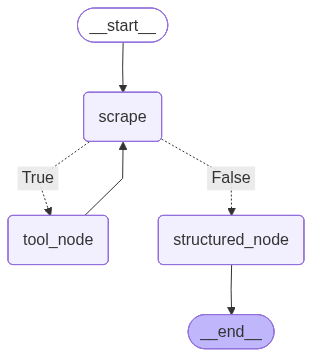

In [5]:
scrape_graph

In [6]:
# INSTRUCTIONS
system_message = """
You are an expert Python web scraper. 
"""
instruction_message = """
You are required to scrape data from the Irish property price register. This website is a registry of property prices in Ireland which can be searched by various criteria.

Scrape using the {address} as the Address, {county} as the County, {year} as the Year, {smonth} as the Start Month, {emonth} as the End Month.

Final Output:
- Return a list of properties with their address, date of sale and price.
"""

messages = [    SystemMessage(content=system_message),
                HumanMessage(content=instruction_message.format(address="Parkview", county="Dublin", year="2024", smonth="", emonth="")) ]

In [7]:
result = scrape_graph.invoke(ScrapingState(messages=messages))
print(result['messages'][-1].content)

Using User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/12...
Viewport size: 1920x1080
Here is a list of properties with their address, date of sale, and price:

*   **Address**: 40 THE WILLOW, PARKVIEW APTS, STEPASIDE, Dublin 18, D18VP26, **Date of Sale**: 02/07/2024, **Price**: €269,000.00
*   **Address**: 49 THE SYCAMORE, PARKVIEW, STEPASIDE DUBLIN 18, Dublin 18, D18FF35, **Date of Sale**: 08/07/2024, **Price**: €279,000.00
*   **Address**: 10 THE OAK PARKVIEW APTS, STEPASIDE, DUBLIN, Dublin 18, D18FN83, **Date of Sale**: 05/07/2024, **Price**: €372,000.00
*   **Address**: 33 PARKVIEW, RATHBOURNE, ASHTOWN, D15V066, **Date of Sale**: 06/08/2024, **Price**: €432,500.00
*   **Address**: 4 CYPRESS HOUSE, PARKVIEW, SEAFIELD SUTTON, Dublin 13, D13V787, **Date of Sale**: 15/10/2024, **Price**: €359,000.00
*   **Address**: APT 5, PARKVIEW, ROBSWALL, K36PW60, **Date of Sale**: 09/09/2024, **Price**: €450,000.00
*   **Address**: 5 PARKVIEW GROVE, JAMEST

In [8]:
result['properties'].properties

[Property(address='40 THE WILLOW, PARKVIEW APTS, STEPASIDE, Dublin 18, D18VP26', date='02/07/2024', price='€269,000.00', type='apartment', bedrooms=0),
 Property(address='49 THE SYCAMORE, PARKVIEW, STEPASIDE DUBLIN 18, Dublin 18, D18FF35', date='08/07/2024', price='€279,000.00', type='unknown', bedrooms=0),
 Property(address='10 THE OAK PARKVIEW APTS, STEPASIDE, DUBLIN, Dublin 18, D18FN83', date='05/07/2024', price='€372,000.00', type='apartment', bedrooms=0),
 Property(address='33 PARKVIEW, RATHBOURNE, ASHTOWN, D15V066', date='06/08/2024', price='€432,500.00', type='unknown', bedrooms=0),
 Property(address='4 CYPRESS HOUSE, PARKVIEW, SEAFIELD SUTTON, Dublin 13, D13V787', date='15/10/2024', price='€359,000.00', type='house', bedrooms=0),
 Property(address='APT 5, PARKVIEW, ROBSWALL, K36PW60', date='09/09/2024', price='€450,000.00', type='apartment', bedrooms=0),
 Property(address='5 PARKVIEW GROVE, JAMESTOWN ROAD, FINGLAS, Dublin 11, D11K275', date='30/08/2024', price='€256,000.00', ty

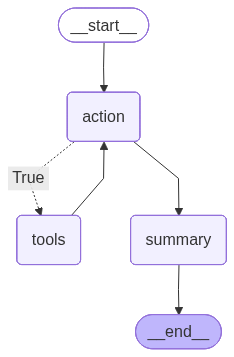

In [9]:
tavily_api_key = os.environ.get("TAVILY_API_KEY")

tavily_server = MultiServerMCPClient(
    {
        "tavily_srv": {
            "transport": "streamable_http",
            "url": f"https://mcp.tavily.com/mcp/?tavilyApiKey={tavily_api_key}",
        }
    })

tools = await tavily_server.get_tools()

# STATE
class SearchState(BaseModel):
    query: str
    messages: Annotated[list[AnyMessage], add_messages] = []

async def action(state: SearchState) -> dict:
    result = await llm.ainvoke(state.messages)
    return {"messages": [result]}

def search_summary_node(state: SearchState) -> dict:
    """Summarizes the search results."""
    messages = [SystemMessage(content="You are a helpful assistant that summarizes internet search results."),
                HumanMessage(content=f"Summarize the following search results for the query. Return the property type and number of bedrooms : {state.query}\n {state.messages[-1].content}")]
    try:
        summary = llm.invoke(messages)
        return {"messages": [summary]}
    except Exception as e:
        error_message = f"Error(summary_node) : {e}"
        return {"messages": [AIMessage(content=error_message)]}


graph = StateGraph(SearchState)
graph.add_node("action", action)
graph.add_node("tools", ToolNode(tools))
graph.add_node("summary", search_summary_node)

graph.add_edge(START, "action")
graph.add_conditional_edges("action", 
    lambda state: len(state.messages[-1].tool_calls) > 0 if hasattr(state.messages[-1], 'tool_calls') else False,
    path_map={True: "tools", False: "summary"}
)
graph.add_edge("tools", "action")
graph.add_edge("action", "summary")
graph.add_edge("summary", END)
compiled_graph = graph.compile()

compiled_graph



In [14]:
messages = [SystemMessage(content="You are a helpful assistant that helps users find information. Search https://myhome.ie and https://daft.ie for property information in Ireland."),
                HumanMessage(content=f"The query is: 49 THE SYCAMORE, PARKVIEW, STEPASIDE DUBLIN 18, Dublin 18, D18FF35")]
query_text = "49 THE SYCAMORE, PARKVIEW, STEPASIDE DUBLIN 18, Dublin 18, D18FF35"
response = await compiled_graph.ainvoke(SearchState(query=query_text, messages=messages))

In [15]:
response['messages'][-1].content

'**Property Type:** Apartment\n**Bedrooms:** 2'

In [56]:
async def create_graphs():
    llm = ChatGoogleGenerativeAI(
        # model=os.getenv("GOOGLE_API_MODEL"),
        model="gemini-2.5-flash",
        temperature=0)

    structure_model = llm.with_structured_output(PropertyList)


    # MAIN GRAPH STATE
    class ScrapingState(BaseModel):
        messages: Annotated[list[AnyMessage], add_messages]
        properties: PropertyList | None = None

    # Property Data Search Subgraph state
    class SubgraphState(BaseModel):
        messages: Annotated[list[AnyMessage], add_messages]
        properties: PropertyList | None = None

   # SUBGRAPH FOR SEARCHING PROPERTY DATA
    tavily_api_key = os.environ.get("TAVILY_API_KEY")

    tavily_server = MultiServerMCPClient(
        {
            "tavily_srv": {
                "transport": "streamable_http",
                "url": f"https://mcp.tavily.com/mcp/?tavilyApiKey={tavily_api_key}",
            }
        })

    tools = await tavily_server.get_tools()


    async def action(state: SubgraphState) -> dict:
    
        result = await llm.ainvoke(state.messages)
        return {"messages": [result]}

    def search_summary_node(state: SubgraphState) -> dict:
        """Summarizes the search results."""
        messages = [SystemMessage(content="You are a helpful assistant that summarizes internet search results."),
                HumanMessage(content=f"Summarize the following search results . Return a list of properties: {state.messages[-1].content}")]
        try:
            result = structure_model.invoke(messages)
            return {"properties": result}
        except Exception as e:
            error_message = f"Error(summary_node) : {e}"
            return {"messages": [AIMessage(content=error_message)]}


    search_graph = StateGraph(SubgraphState)
    search_graph.add_node("action", action)
    search_graph.add_node("tools", ToolNode(tools))
    search_graph.add_node("summary", search_summary_node)

    search_graph.add_edge(START, "action")
    search_graph.add_conditional_edges("action", 
        lambda state: state.messages[-1].tool_calls == [] if state.messages else True,
    path_map={True: "summary", False: "tools"}
    )
    search_graph.add_edge("tools", "action")
    search_graph.add_edge("summary", END)
    compiled_search_graph = search_graph.compile()


    

    ##### MAIN GRAPH NODES
    def structure_node(state: ScrapingState) -> dict:

        msgs = [HumanMessage(content="Structure the following property data into a PropertyList format:\n" + str(state.messages[-1].content))]

        response = structure_model.invoke(msgs)

        return {"properties": response}

    def scrape_property_data_node(state: ScrapingState) -> dict:
    
        result = llm.bind_tools(tools=[scrape_property_data]).invoke(state.messages)
        return {"messages": result}

    # Entrance to search property data subgraph
    def search_property_data_node(state: ScrapingState) -> dict:
        messages = [SystemMessage(content="You are a helpful assistant that helps users find information. You will be provided a list of properties. For each property, search https://myhome.ie and https://daft.ie for property information in Ireland and return a list of properties")]

        subgraph_state = SubgraphState(messages=messages, properties=state.properties)  # Pass the properties from parent state
        # Transform the state to the subgraph state
        subgraph_output = compiled_search_graph.invoke(subgraph_state)  
        # Transform response back to the parent state
        return {"properties": subgraph_output["properties"]}    


    # MAIN GRAPH
    scrape_graph = StateGraph(ScrapingState)
    scrape_graph.add_node("scrape", scrape_property_data_node)
    scrape_graph.add_node("tool_node", ToolNode(tools=[scrape_property_data]))#
    scrape_graph.add_node("structured_node", structure_node)
    scrape_graph.add_node("search_property_data", search_property_data_node)            

    scrape_graph.add_conditional_edges("scrape", 
        lambda state: len(state.messages[-1].tool_calls) > 0 if hasattr(state.messages[-1], 'tool_calls') else False,
        path_map={True: "tool_node", False: "structured_node"}
    )
    scrape_graph.add_edge(START, "scrape")
    scrape_graph.add_edge("tool_node", "scrape")
    scrape_graph.add_edge("structured_node", "search_property_data")
    scrape_graph.add_edge("search_property_data", END)
    compiled_scrape_graph = scrape_graph.compile()

    return compiled_scrape_graph 

# Create the graphs
compiled_scrape_graph = asyncio.run(create_graphs())




RuntimeError: asyncio.run() cannot be called from a running event loop

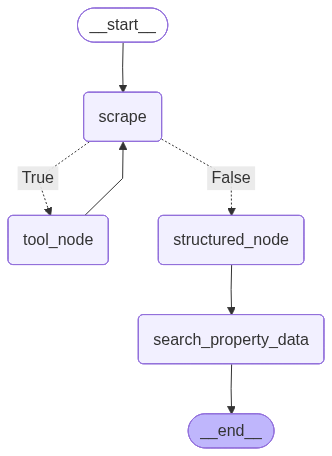

In [53]:
# MAIN GRAPH
compiled_scrape_graph

In [54]:
# INSTRUCTIONS
system_message = """
You are an expert Python web scraper. 
"""
instruction_message = """
You are required to scrape data from the Irish property price register. This website is a registry of property prices in Ireland which can be searched by various criteria.

Scrape using the {address} as the Address, {county} as the County, {year} as the Year, {smonth} as the Start Month, {emonth} as the End Month.

Final Output:
- Return a list of properties with their address, date of sale and price.
"""

messages = [    SystemMessage(content=system_message),
                HumanMessage(content=instruction_message.format(address="Parkview", county="Dublin", year="2024", smonth="", emonth="")) ]

In [55]:
result = compiled_scrape_graph.invoke(ScrapingState(messages=messages))
print(result['messages'][-1].content)

Using User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/12...
Viewport size: 1536x864


TypeError: No synchronous function provided to "action".
Either initialize with a synchronous function or invoke via the async API (ainvoke, astream, etc.)

E0000 00:00:1766508658.309465    5093 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


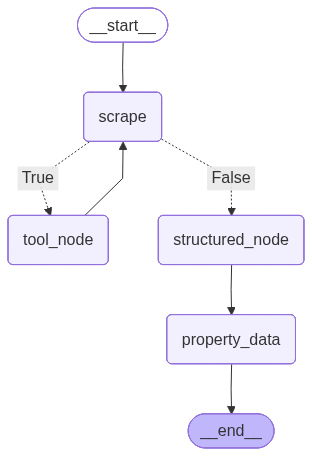

In [73]:
# COMMON IMPORTS
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langchain.tools import tool

from pydantic import BaseModel, Field
from typing_extensions import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langchain_core.messages import (HumanMessage, SystemMessage, AIMessage, ToolMessage, AnyMessage)

from langgraph.graph.message import add_messages
import asyncio, random, os
from playwright.async_api import async_playwright
load_dotenv()

class Property(BaseModel):
    address: str = Field(description="The address of the property")
    date: str = Field(description="The date the property was sold")
    price: str = Field(description="The price of the property")

class PropertyList(BaseModel):
    properties: list[Property] = Field(description="A list of properties sold")


#TOOLS
@tool
def scrape_property_data(address="Belmont", county="Dublin", year="2024", 
                          start_month=None, end_month=None, verbose=False):
    """
    Scrape Irish property price data from the Property Price Register.
    
    Args:
        address (str): Address to search for (default: "Belmont")
        county (str): County to search in (default: "Dublin")
        year (str): Year to search (default: "2024")
        start_month (str, optional): Start month in "01"-"12" format
        end_month (str, optional): End month in "01"-"12" format
        verbose (bool): Whether to print progress messages (default: False)
    
    Returns:
        list: List of dictionaries containing property data, or empty list if no results
    """
    async def _async_scrape():
        def log(message):
            if verbose:
                print(message)
        
        async with async_playwright() as p:
            # Simplified browser launch
            browser = await p.chromium.launch(headless=True)
            context = await browser.new_context(
                user_agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36",
                viewport={"width": 1920, "height": 1080}
            )
            page = await context.new_page()
            
            try:
                log(f"\nSearching for:")
                log(f"  Address: {address}")
                log(f"  County: {county}")
                log(f"  Year: {year}")
                if start_month:
                    log(f"  Start Month: {start_month}")
                if end_month:
                    log(f"  End Month: {end_month}")
                log("")

                # Navigate to page
                await page.goto("https://www.propertypriceregister.ie/website/npsra/pprweb.nsf/PPR?OpenForm")
                await asyncio.sleep(2)

                # Accept all cookies if the banner is present
                cookie_accept = page.locator("#cookiescript_accept")
                if await cookie_accept.count() > 0 and await cookie_accept.is_visible():
                    log("Accepting cookies...")
                    await cookie_accept.click()
                    await asyncio.sleep(1)

                # Fill the form fields
                log("Filling form...")
                await page.fill("#Address", address)
                await page.select_option("#County", county)
                await page.select_option("#Year", year)
                
                # Fill start month if provided
                if start_month:
                    await page.select_option("#StartMonth", start_month)
                
                # Fill end month if provided  
                if end_month:
                    await page.select_option("#EndMonth", end_month)

                # Click the 'Perform Search' button
                log("Submitting search...")
                await asyncio.sleep(1)
                async with page.expect_navigation():
                    await page.click("input[value='Perform Search']")
                
                await asyncio.sleep(2)

                # Wait for the results table to load
                try:
                    await page.wait_for_selector("#searchResultsTbl", timeout=15000)
                    log("Results table loaded.")
                except:
                    # Check if there are no results
                    page_content = await page.content()
                    if "no results" in page_content.lower() or "no records" in page_content.lower():
                        log("No results found for the search criteria.")
                        return []
                    else:
                        log("Table not found, but continuing...")
                
                await asyncio.sleep(1)

                all_results = []
                page_number = 1
                
                while True:
                    log(f"\nProcessing page {page_number}...")
                    
                    # Check if table exists on current page
                    if await page.locator("#searchResultsTbl").count() == 0:
                        log("Results table not found on this page.")
                        break
                    
                    # Extract results from current page
                    rows = await page.locator("#searchResultsTbl tbody tr").all()
                    
                    if len(rows) == 0:
                        log("No rows found in table.")
                        break
                    
                    for row in rows:
                        # Get all text content from table cells
                        cols = await row.locator("td").all_text_contents()
                        
                        if len(cols) >= 3:
                            # Try to get address from the link first
                            address_link = row.locator("td:nth-child(3) a")
                            address_text = ""
                            
                            if await address_link.count() > 0:
                                address_text = await address_link.inner_text()
                            else:
                                address_text = cols[2]
                            
                            all_results.append({
                                "Date of Sale": cols[0].strip(),
                                "Price": cols[1].strip(),
                                "Address": address_text.strip(),
                                "Page": page_number
                            })
                    
                    # Get the total results info if available
                    info_locator = page.locator("#searchResultsTbl_info")
                    if await info_locator.count() > 0:
                        info_text = await info_locator.inner_text()
                        log(f"  Found {len(rows)} rows. {info_text}")
                    else:
                        log(f"  Found {len(rows)} rows.")
                    
                    # Check if we're on the last page
                    next_button = page.locator("#searchResultsTbl_next")
                    
                    if await next_button.count() == 0:
                        log("No next button found - stopping.")
                        break
                    
                    # Check if the button has the 'disabled' class
                    is_disabled = await next_button.evaluate('(element) => element.classList.contains("disabled")')
                    
                    if is_disabled:
                        log("Next button is disabled - reached last page.")
                        break
                    else:
                        log("Clicking next button...")
                        await next_button.click()
                        
                        # Wait for page load
                        await asyncio.sleep(2)
                        
                        # Additional wait for table
                        try:
                            await page.wait_for_function(
                                """() => {
                                    const rows = document.querySelectorAll('#searchResultsTbl tbody tr');
                                    return rows.length > 0;
                                }""",
                                timeout=8000
                            )
                        except:
                            await asyncio.sleep(1)
                        
                        page_number += 1
                        if page_number > 50:  # Safety limit
                            log("Reached safety limit of 50 pages - stopping.")
                            break
                
                log(f"\n{'='*60}")
                log(f"Total results found: {len(all_results)}")
                
                if all_results and verbose:
                    # Display summary
                    print(f"\nFirst 3 results:")
                    for i, entry in enumerate(all_results[:3]):
                        print(f"{i+1}. {entry['Date of Sale']} - {entry['Price']}")
                        print(f"   {entry['Address'][:60]}...")
                        print()
                    
                    # Statistics
                    try:
                        prices = [
                            float(entry['Price'].replace('€', '').replace(',', '').replace('**', '').strip())
                            for entry in all_results
                        ]
                        print(f"Statistics:")
                        print(f"  Average price: €{sum(prices)/len(prices):,.2f}")
                        print(f"  Price range: €{min(prices):,.2f} - €{max(prices):,.2f}")
                    except:
                        pass
                
                return all_results
                    
            except Exception as e:
                if verbose:
                    print(f"Error occurred: {e}")
                    import traceback
                    traceback.print_exc()
                return []
                
            finally:
                # Close browser
                await browser.close()
                if verbose:
                    print("\nBrowser closed.")
    
    # Synchronous entry point that runs the async function
    return asyncio.run(_async_scrape())

# code execution tool
import contextlib
import io

@tool
def execute_code(code: str = Field(description="Code to be executed.")) -> str:
    """Executes the given Python code and returns the output or error message.
        You have access to the pandas library."""
    try:
        with contextlib.redirect_stdout(io.StringIO()) as f:
            exec(code)
        result = f.getvalue()    
    except Exception as e:
            result = f"Error: {e}"
    return result



# MAIN GRAPH STATE
class ScrapingState(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]
    properties: PropertyList | None = None

# Property Data Search Subgraph state
class SubgraphState(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]
    properties: PropertyList | None = None

#MODELS
llm = ChatGoogleGenerativeAI(
    # model=os.getenv("GOOGLE_API_MODEL"),
    model="gemini-2.5-flash",
    temperature=0)

structure_model = llm.with_structured_output(PropertyList)


# STATE
class ScrapingState(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]
    properties: PropertyList | None = None

#SUBGRAPH NODES
#def generate_code_node(state: SubgraphState) -> dict:
    
    # bind the tool to the llm
#    execution_llm = llm.bind_tools([execute_code])    
    # invoke the llm with messages passed via the state
#    result = execution_llm.invoke(state.messages)
    # return result for LangGraph to update against the messages field of the state
#    return {"messages": result}

tools = [execute_code]
tool_llm = llm.bind_tools(tools)

def generate_code_node(state: SubgraphState) -> dict:
    # Bind the tool to the llm
      
    # Debug the messages being sent
    print(f"DEBUG - Messages being sent to LLM: {state.messages}")
    
    # Invoke the llm
    result = tool_llm.invoke(state.messages)
    print(f"Generate Code Node Result: {result}")
    print(f"DEBUG - Result type: {type(result)}")
    print(f"DEBUG - Result content: {result.content}")
    print(f"DEBUG - Result additional_kwargs: {result.additional_kwargs}")
    
    return {"messages": result}

#COMPILE SUBGRAPH

data_analysis_graph = StateGraph(SubgraphState)
data_analysis_graph.add_node("code", generate_code_node)
data_analysis_graph.add_node("execute", ToolNode(tools=[execute_code]))

data_analysis_graph.add_edge(START, "code")
data_analysis_graph.add_conditional_edges("code", lambda state: state.messages[-1].tool_calls == [],
                            path_map={True: END, False: "execute"})
data_analysis_graph.add_edge("execute", "code")


data_analysis_graph = data_analysis_graph.compile()


# MAIN GRAPH NODES
def structure_node(state: ScrapingState) -> dict:

    msgs = [HumanMessage(content="Structure the following property data into a PropertyList format:\n" + str(state.messages[-1].content))]

    response = structure_model.invoke(msgs)

    return {"properties": response}

def scrape_property_data_node(state: ScrapingState) -> dict:
    
    result = llm.bind_tools(tools=[scrape_property_data]).invoke(state.messages)
    #print(f"Scrape Node Result: {result.messages[-1]}")
    return {"messages": state.messages + [result]}

# Entrance to property data subgraph
def property_data_node(state: ScrapingState) -> dict:
    # Only if we have properties
    if not state.properties or not state.properties.properties:
        return {"messages": [AIMessage(content="No properties available.")]}
    else:
        # INSTRUCTIONS
        system_prompt = """You are an expert Python programmer and data scientist. 
        Your task is to analyse the provided property data.
        """ 
    
        # Convert properties to string
        properties_data = ""
        if state.properties and state.properties.properties:
            properties_data = "\nProperties to analyze:\n"
            for i, prop in enumerate(state.properties.properties):
                properties_data += f"{i+1}. Address: {prop.address}, Date: {prop.date}, Price: {prop.price}\n"
    
        instruction_message = f"""Write Python code to analyze the provided property data using pandas.

        1. Create a pandas DataFrame from the properties provided
        2. Clean the data (convert price to numeric, parse dates)
        3. Compute statistics (average, min, max, count)

        \n\n{properties_data}"""



        #print(f"USER PROMPT:\n{user_prompt}\n")

        # Create messages
        messages = [
            SystemMessage(content=system_prompt),
            HumanMessage(content=instruction_message)
        ]
        subgraph_state = SubgraphState(messages=messages, properties=state.properties)
        # Transform the state to the subgraph state
        subgraph_output = data_analysis_graph.invoke(subgraph_state)  
        # Transform response back to the parent state
        
        return {"messages": subgraph_output['messages']}
        

            
 

# MAIN GRAPH
graph = StateGraph(ScrapingState)
graph.add_node("scrape", scrape_property_data_node)
graph.add_node("tool_node", ToolNode(tools=[scrape_property_data]))#
graph.add_node("structured_node", structure_node)
graph.add_node("property_data", property_data_node)

graph.add_conditional_edges("scrape", 
    lambda state: len(state.messages[-1].tool_calls) > 0 if hasattr(state.messages[-1], 'tool_calls') else False,
    path_map={True: "tool_node", False: "structured_node"}
)


graph.add_edge(START, "scrape")
graph.add_edge("tool_node", "scrape")
graph.add_edge("structured_node", "property_data")
graph.add_edge("property_data", END)




scrape_graph = graph.compile()
scrape_graph



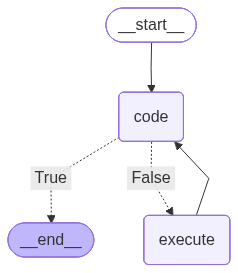

In [74]:
data_analysis_graph

In [75]:
# INSTRUCTIONS
system_message = """
You are an expert Python web scraper. 
"""
instruction_message = """
You are required to scrape data from the Irish property price register. This website is a registry of property prices in Ireland which can be searched by various criteria.

Scrape using the {address} as the Address, {county} as the County, {year} as the Year, {smonth} as the Start Month, {emonth} as the End Month.

Final Output:
- Return a list of properties with their address, date of sale and price.
"""

messages = [    SystemMessage(content=system_message),
                HumanMessage(content=instruction_message.format(address="Belmont", county="Dublin", year="2024", smonth="", emonth="")) ]

result = scrape_graph.invoke(ScrapingState(messages=messages))
print(result['messages'][-1].content)
print(result)

DEBUG - Messages being sent to LLM: [SystemMessage(content='You are an expert Python programmer and data scientist. \n        Your task is to analyse the provided property data.\n        ', additional_kwargs={}, response_metadata={}, id='66789535-2a42-4fda-9fec-89b601b79391'), HumanMessage(content="Write Python code to analyze the provided property data using pandas.\n\n        1. Create a pandas DataFrame from the properties provided\n        2. Clean the data (convert price to numeric, parse dates)\n        3. Compute statistics (average, min, max, count)\n\n        \n\n\nProperties to analyze:\n1. Address: 28 BELMONT SQ, RAHENY, DUBLIN 5, Dublin 5, D05TW13, Date: 04/11/2024, Price: €387,000.00\n2. Address: 51 BELMONT AVE, DONNYBROOK, DUBLIN 4, Dublin 4, D04V6Y4, Date: 14/10/2024, Price: €1,360,000.00\n3. Address: 167 BELMONT PARK, RAHENY, DUBLIN 5, Dublin 5, D05HP08, Date: 08/10/2024, Price: €80,000.00\n4. Address: 6 BELMONT COURT, PHILIPSBURGH AVENUE, DUBLIN 3, D03E2W6, Date: 19/09